In [ ]:
# https://pyimagesearch.com/2015/05/25/basic-motion-detection-and-tracking-with-python-and-opencv/

In [36]:
import cv2
import urllib3
import imutils
import base64
import time
import numpy as np
from datetime import datetime
from matplotlib import pyplot as plt
from IPython.display import clear_output

In [24]:
ip = '192.168.1.52'
port = 1025
user = ''
passw = ''

class IPCamera(object):
    def __init__(self, url, user=None, password=None):
        self.url = url
        self.http = urllib3.PoolManager()
        self.auth_encoded = base64.b64encode(('%s:%s' % (user, password)).encode())[:-1].decode()     

    def get_frame(self):
        response = self.http.request('GET', self.url, headers={'Authorization': f'Basic {self.auth_encoded}'})
        #print(response.__dict__)
        if response.status == 200:
            img_array = np.asarray(bytearray(response.data), dtype=np.uint8)
            frame = cv2.imdecode(img_array, 1)
            return frame
        else:
            return None

cam = IPCamera(f'http://{user}:{passw}@{ip}:{port}/snap.jpg?JpegSize=XL', user, passw)

def get_frame():
    return cam.get_frame()

Check for next frame


array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>], dtype=object)

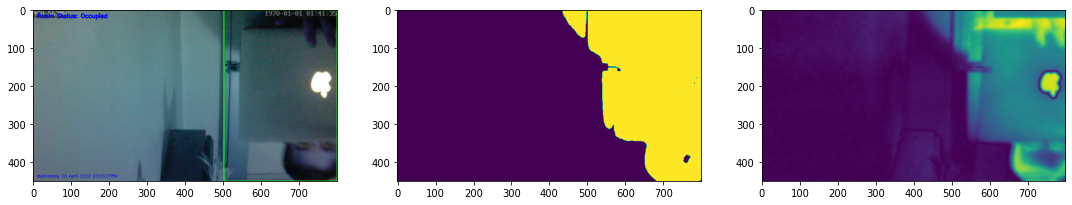

In [51]:
first_frame = None
min_area = 200
width = 800
fig, axes = plt.subplots(1, 3)
fig.set_size_inches(18.5, 10.5)
clear_output(wait=True)

# loop over the frames of the video
while True:
    clear_output(wait=True)
    # grab the current frame and initialize the occupied/unoccupied
    # text
    frame = get_frame()
    text = "Unoccupied"
    
    # if the frame could not be grabbed, then we have reached the end
    # of the video
    if frame is None:
        break
    
    # resize the frame, convert it to grayscale, and blur it
    frame = imutils.resize(frame, width=width)
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (21, 21), 0)
    
    # if the first frame is None, initialize it
    if first_frame is None:
        first_frame = gray
        continue
        
    # Compute the absolute difference between the current frame and
    # first frame
    frame_delta = cv2.absdiff(first_frame, gray)
    thresh = cv2.threshold(frame_delta, 25, 255, cv2.THRESH_BINARY)[1]
    
    # Dilate the thresholded image to fill in holes, then find contours
    # on thresholded image
    thresh = cv2.dilate(thresh, None, iterations=2)
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL,
        cv2.CHAIN_APPROX_SIMPLE)
    
    cnts = imutils.grab_contours(cnts)
    #display(f'Contours={cnts}')
    
    # Loop over the contours
    for c in cnts:
        # if the contour is too small, ignore it
        area = cv2.contourArea(c)
        if area < min_area:
            print(f'Contour area {area} < min area {min_area}')
            continue
        # compute the bounding box for the contour, draw it on the frame,
        # and update the text
        (x, y, w, h) = cv2.boundingRect(c)
        cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 0), 2)
        text = "Occupied"
        break
        
    # Draw the text and timestamp on the frame
    cv2.putText(frame, "Room Status: {}".format(text), (10, 20), 
                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2)
    cv2.putText(frame, datetime.now().strftime("%A %d %B %Y %I:%M:%S%p"),
                (10, frame.shape[0] - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.35, (0, 0, 255), 1)
    
    # Show the frame and record if the user presses a key
    axes[0].imshow(frame)
    axes[1].imshow(thresh)
    axes[2].imshow(frame_delta)
    
    key = cv2.waitKey(1) & 0xFF
    # if the `q` key is pressed, break from the lop
    if key == ord("q"):
        break
    
    print('Check for next frame')
    display(axes)
    time.sleep(1)
    
    if len(cnts):
        break
        
    #break